# Object Orientated Sign Detection NN

In [2]:

!pip install --upgrade tensorflow tensorboard --user
!pip install tensorflow-gpu --user


Requirement already up-to-date: tensorflow in c:\users\aleja\documents\anaconda3\lib\site-packages (1.11.0)
Requirement already up-to-date: tensorboard in c:\users\aleja\documents\anaconda3\lib\site-packages (1.11.0)


In [1]:
#import all packages
import h5py
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import Parametised_tf_utils
from Parametised_tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from tensorflow.python.framework import ops
from ParameterExportation import ParameterExportation
import ParameterExportation
import matplotlib.pyplot as plt

C:\Users\aleja\Documents\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
class Sign_Language_Detection():
    num_epochs = 1500
    minibatch_size = 32
    print_cost = True
    learning_rate = 0.0001
    #parameters = Sign_Language_Detection.parameters
    class Data_Preparation():
        def __init__(self,n_x,n_y):
            self.n_x=n_x
            self.n_y=n_y
        def M_data_collection(self):
            # Loading the dataset
            X_train_orig, Y_train_orig, X_test_orig,Y_test_orig, classes = load_dataset("Dataset/train_signs.h5","Dataset/test_signs.h5")      
            return X_train_orig, Y_train_orig, X_test_orig,Y_test_orig, classes
        def M_data_normalization(self):
            # Flatten the training and test images
            X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1 ).T
            X_test_flatten =  X_test_orig.reshape(X_test_orig.shape[0], -1).T
            #Normalize Data
            X_train=X_train_flatten/255
            X_test=X_test_flatten/255
            #Convert to one hot encoding, Function= convert_to_one_hot
            Y_train=convert_to_one_hot(Y_train_orig,6) #First parameter-the Data and second the Number of classes(Y,C)
            Y_test=convert_to_one_hot(Y_test_orig,6) #First parameter-the Data and second the Number of classes(Y,C)
            return X_train,X_test,Y_train,Y_test
    class Forward_Propagation(Data_Preparation):       
            def __init__(self,n_x,n_y,layer_dims,parameters):
                super().__init__(n_x,n_y)
                self.layer_dims=layer_dims
                self.parameters=parameters
            def M_create_placeholders(self):
                X= tf.placeholder(tf.float32,shape=[self.n_x,None] ,name='X')
                Y= tf.placeholder(tf.float32,shape=[self.n_y,None] ,name='Y')

                return X, Y
            def M_initialize_parameters_parametized(self):
                L = len(self.layer_dims)  
                for l in range(1, L):
                    self.parameters['W' + str(l)] = tf.get_variable("W"+str(l),[self.layer_dims[l], self.layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
                    self.parameters['b' + str(l)] = tf.get_variable("b"+str(l),[self.layer_dims[l], 1],initializer=tf.zeros_initializer)
                    assert(self.parameters['W' + str(l)].shape == (self.layer_dims[l], self.layer_dims[l-1]))
                    assert(self.parameters['b' + str(l)].shape == (self.layer_dims[l], 1))
                return self.parameters

            def M_forward_propagation(self,X,parameters):
                L = len(self.layer_dims)  
                Z_Parameters={

                }
                A=[]
                Z_L_Iteration="0"
                A.append(X)
                for l in range(1,L):
                    Z_Parameters["Z"+str(l)]=tf.add(tf.matmul(self.parameters["W"+str(l)],A[l-1]),self.parameters["b"+str(l)])
                    A.append(tf.nn.relu(Z_Parameters["Z"+str(l)]))  
                    if l == L-1:
                        Z_L_Iteration=Z_Parameters["Z"+str(l)]
                return Z_Parameters,A,Z_L_Iteration

    class Back_Propagation(Forward_Propagation):
        def __init__(self,n_x,n_y,layer_dims,X_train, Y_train, X_test, Y_test):
            super().__init__(n_x,n_y,layer_dims,parameters)
            self.X_train=X_train
            self.Y_train=Y_train
            self.X_test=X_test
            self.Y_test=Y_test
        def M_compute_cost(self,Z,Y):
            logits=tf.transpose(Z)
            labels=tf.transpose(Y)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                                                          logits = logits,
                                                                          labels =labels))
            return cost
        def M_Back_Prop(self):
        
            #ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
            tf.set_random_seed(1)                             # to keep consistent results
            seed = 3                                          # to keep consistent results
            (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
            n_y = Y_train.shape[0]                            # n_y : output size
            costs = []                                        # To keep track of the cost

            L=len(self.layer_dims)
            learning_rate=Sign_Language_Detection.learning_rate
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
            num_epochs=Sign_Language_Detection.num_epochs
            minibatch_size=Sign_Language_Detection.minibatch_size
            print_cost = True
            init = tf.global_variables_initializer()
    
            with tf.Session() as sess:
                sess.run(init)
                for epoch in range(num_epochs):

                    epoch_cost = 0.                       # Defines a cost related to an epoch
                    num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                    seed = seed + 1
                    minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
                    for minibatch in minibatches:

                        (minibatch_X, minibatch_Y) = minibatch
                        _ , minibatch_cost = sess.run([optimizer, cost], 
                                                     feed_dict={X: minibatch_X, 
                                                                Y: minibatch_Y})
                        epoch_cost += minibatch_cost / num_minibatches

                    # Print the cost every epoch
                    if print_cost == True and epoch % 100 == 0:
                        print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                    if print_cost == True and epoch % 5 == 0:
                        costs.append(epoch_cost)

                # plot the cost
                plt.plot(np.squeeze(costs))
                plt.ylabel('cost')
                plt.xlabel('iterations (per tens)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()

                # lets save the parameters in a variable
                parameters = sess.run(self.parameters)
                print ("Parameters have been trained!")

                # Calculate the correct predictions
                correct_prediction = tf.equal(tf.argmax(Z_L_Iteration), tf.argmax(Y))

                # Calculate accuracy on the test set
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

                print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
                print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

                return parameters

In [8]:

tf.reset_default_graph()
with tf.Session() as sess:
    parameters = {} 
    layer_dims = [12288,25,12,6] 
    
    FirstSLD=Sign_Language_Detection()
    FirstDP=FirstSLD.Data_Preparation(12288,6)
    X_train_orig, Y_train_orig, X_test_orig,Y_test_orig, classes=FirstDP.M_data_collection()
    X_train,X_test,Y_train,Y_test = FirstDP.M_data_normalization()
    FirstFP=FirstSLD.Forward_Propagation(12288,6,layer_dims,parameters)
    X ,Y = FirstFP.M_create_placeholders()
    parameters = FirstFP.M_initialize_parameters_parametized()
    Z_Parameters,A,Z_L_Iteration = FirstFP.M_forward_propagation(X,parameters)
    print("X =" + str(X))
    print("Y =" + str(Y))
    L=len(layer_dims)
    for l in range(1,L):
        print("W"+str(l)+"=" + str(parameters["W"+str(l)]))
        print("b"+str(l)+"=" + str(parameters["b"+str(l)]))
    print("Z = " + str(Z_Parameters))
    print("A =" +str(A))
    print("Z3 =" + str(Z_L_Iteration))
    FirstMBP=FirstSLD.Back_Propagation(12288,6,layer_dims,X_train,Y_train,X_test,Y_test)
    cost=FirstMBP.M_compute_cost(Z_L_Iteration,Y)
    parameters=FirstMBP.M_Back_Prop()

X =Tensor("X:0", shape=(12288, ?), dtype=float32)
Y =Tensor("Y:0", shape=(6, ?), dtype=float32)
W1=<tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1=<tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2=<tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2=<tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3=<tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3=<tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>
Z = {'Z1': <tf.Tensor 'Add:0' shape=(25, ?) dtype=float32>, 'Z2': <tf.Tensor 'Add_1:0' shape=(12, ?) dtype=float32>, 'Z3': <tf.Tensor 'Add_2:0' shape=(6, ?) dtype=float32>}
A =[<tf.Tensor 'X:0' shape=(12288, ?) dtype=float32>, <tf.Tensor 'Relu:0' shape=(25, ?) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(12, ?) dtype=float32>, <tf.Tensor 'Relu_2:0' shape=(6, ?) dtype=float32>]
Z3 =Tensor("Add_2:0", shape=(6, ?), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by def

NameError: name 'X_train' is not defined

Your algorithm predicts: y = 2

C:\Users\aleja\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\aleja\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


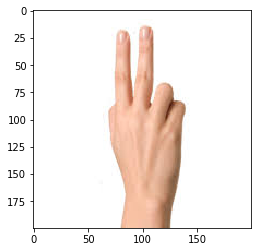

In [28]:
import scipy
from PIL import Image
from scipy import ndimage
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "img1.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
layers_dims = [12288,25,12,6] 
fname = "Images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters,layers_dims)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))